# Parkings forecasting with Prophet for Porthaninkatu 6

## Initial setup

In [77]:
import pandas as pd
import numpy as np
import warnings
import logging
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

from utils import (get_forecast_total_sum, cross_validate, optimize_prophet_params,
                   print_best_params, percent_difference)

In [78]:
warnings.filterwarnings("ignore", category=FutureWarning)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

## Data loading and cleaning

In [79]:
df = pd.read_csv("../data/parkings_small.csv") # all zones
df = df[df['parking_area_id'] == 'ce8f3960-fc3f-4cc7-87f5-9cd5532e09bc'] # porthaninkatu 6
df['time_start'] = pd.to_datetime(df['time_start'], format="ISO8601")
df['time_end'] = pd.to_datetime(df['time_end'], format="ISO8601")

In [80]:
rain_df = pd.read_csv('../data/artukainen_rain.csv')
rain_df['timestamp'] = pd.to_datetime(rain_df['timestamp'])
rain_df = rain_df.rename(columns={"timestamp": "ds", "value": "rain"})

In [81]:
temp_df = pd.read_csv('../data/artukainen_temperature.csv')
temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp'])
temp_df = temp_df.rename(columns={"timestamp": "ds", "value": "temp"})

### Hourly time series for parking occupancy

In [82]:

# Generate hourly timestamps for each hour eg 0, 1, 2
hourly_index = pd.date_range(start=df['time_start'].min().floor('h'),
                             end=df['time_end'].max().ceil('h'),
                             freq='h')

# Initialize an empty DataFrame for hourly occupancy counts
hourly_parking = pd.DataFrame({'ds': hourly_index})

# Count active parkings in each hour
def count_active_parkings(timestamp):
    return ((df['time_start'] <= timestamp) & (df['time_end'] > timestamp)).sum()
    # time stamp is between start and end time of parking

hourly_parking['y'] = hourly_parking['ds'].apply(count_active_parkings)
hourly_parking['ds'] = hourly_parking['ds'].dt.tz_localize(None)
hourly_parking.head()

,ds,y
0,2024-05-20 02:00:00,0
1,2024-05-20 03:00:00,1
2,2024-05-20 04:00:00,7
3,2024-05-20 05:00:00,11
4,2024-05-20 06:00:00,21


### Rain and temperature data merging

In [83]:
# Merge rain data
hourly_parking = pd.merge(hourly_parking, rain_df, on='ds', how='left')
# 3mm of rain is considered as rain
hourly_parking['rain_bool'] = hourly_parking['rain'] >= 3.0
# Merge temperature data
hourly_parking = pd.merge(hourly_parking, temp_df, on='ds', how='left')
hourly_parking.tail()

,ds,y,rain,rain_bool,temp
6299,2025-02-06 13:00:00,41,0.0,False,3.1
6300,2025-02-06 14:00:00,25,0.0,False,3.0
6301,2025-02-06 15:00:00,8,0.0,False,1.9
6302,2025-02-06 16:00:00,3,0.0,False,0.0
6303,2025-02-06 17:00:00,0,0.0,False,-0.5


## Prophet model parameter testing

In [84]:
#best_params_rmse, results_df_rmse = optimize_prophet_params(hourly_parking, target_metric='rmse')
#print_best_params(best_params_rmse, results_df_rmse)
''' results
Best Parameters:
changepoint_prior_scale: 0.001
seasonality_prior_scale: 1.0
seasonality_mode: additive
changepoint_range: 0.8
interval_width: 0.95
Best score: 9.91

Top 5 Parameter Combinations:
    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  changepoint_range  interval_width     score
17                    0.001                      1.0         additive               0.80            0.99  9.910543
16                    0.001                      1.0         additive               0.80            0.95  9.910543
23                    0.001                      1.0         additive               0.95            0.99  9.912444
22                    0.001                      1.0         additive               0.95            0.95  9.912444
9                     0.001                      0.1         additive               0.80            0.99  9.916386
'''

' results\nBest Parameters:\nchangepoint_prior_scale: 0.001\nseasonality_prior_scale: 1.0\nseasonality_mode: additive\nchangepoint_range: 0.8\ninterval_width: 0.95\nBest score: 9.91\n\nTop 5 Parameter Combinations:\n    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  changepoint_range  interval_width     score\n17                    0.001                      1.0         additive               0.80            0.99  9.910543\n16                    0.001                      1.0         additive               0.80            0.95  9.910543\n23                    0.001                      1.0         additive               0.95            0.99  9.912444\n22                    0.001                      1.0         additive               0.95            0.95  9.912444\n9                     0.001                      0.1         additive               0.80            0.99  9.916386\n'

In [85]:
#best_params_rmse_rain, results_df_rmse_rain = optimize_prophet_params(hourly_parking, target_metric='rmse', incl_rain=True)
#print_best_params(best_params_rmse_rain, results_df_rmse_rain)
''' results
Best Parameters:
changepoint_prior_scale: 0.001
seasonality_prior_scale: 0.1
seasonality_mode: additive
changepoint_range: 0.95
interval_width: 0.95
Best score: 9.89

Top 5 Parameter Combinations:
    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  changepoint_range  interval_width     score
15                    0.001                      0.1         additive               0.95            0.99  9.892050
14                    0.001                      0.1         additive               0.95            0.95  9.892050
30                    0.001                     10.0         additive               0.95            0.95  9.911707
31                    0.001                     10.0         additive               0.95            0.99  9.911707
17                    0.001                      1.0         additive               0.80            0.99  9.913169
'''

' results\nBest Parameters:\nchangepoint_prior_scale: 0.001\nseasonality_prior_scale: 0.1\nseasonality_mode: additive\nchangepoint_range: 0.95\ninterval_width: 0.95\nBest score: 9.89\n\nTop 5 Parameter Combinations:\n    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  changepoint_range  interval_width     score\n15                    0.001                      0.1         additive               0.95            0.99  9.892050\n14                    0.001                      0.1         additive               0.95            0.95  9.892050\n30                    0.001                     10.0         additive               0.95            0.95  9.911707\n31                    0.001                     10.0         additive               0.95            0.99  9.911707\n17                    0.001                      1.0         additive               0.80            0.99  9.913169\n'

In [86]:
#best_params_rmse_temp, results_df_rmse_temp = optimize_prophet_params(hourly_parking, target_metric='rmse', incl_temp=True)
#print_best_params(best_params_rmse_temp, results_df_rmse_temp)
''' results
Best Parameters:
changepoint_prior_scale: 0.001
seasonality_prior_scale: 100.0
seasonality_mode: additive
changepoint_range: 0.8
interval_width: 0.95
Best score: 9.93

Top 5 Parameter Combinations:
    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  changepoint_range  interval_width     score
33                    0.001                    100.0         additive               0.80            0.99  9.929636
32                    0.001                    100.0         additive               0.80            0.95  9.929636
18                    0.001                      1.0         additive               0.85            0.95  9.938277
19                    0.001                      1.0         additive               0.85            0.99  9.938277
27                    0.001                     10.0         additive               0.85            0.99  9.940017
'''

' results\nBest Parameters:\nchangepoint_prior_scale: 0.001\nseasonality_prior_scale: 100.0\nseasonality_mode: additive\nchangepoint_range: 0.8\ninterval_width: 0.95\nBest score: 9.93\n\nTop 5 Parameter Combinations:\n    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  changepoint_range  interval_width     score\n33                    0.001                    100.0         additive               0.80            0.99  9.929636\n32                    0.001                    100.0         additive               0.80            0.95  9.929636\n18                    0.001                      1.0         additive               0.85            0.95  9.938277\n19                    0.001                      1.0         additive               0.85            0.99  9.938277\n27                    0.001                     10.0         additive               0.85            0.99  9.940017\n'

In [87]:
#best_params_rmse_rain_temp, results_df_rmse_rain_temp = optimize_prophet_params(hourly_parking, target_metric='rmse', incl_rain=True, incl_temp=True)
#print_best_params(best_params_rmse_rain_temp, results_df_rmse_rain_temp)
''' results
Best Parameters:
changepoint_prior_scale: 0.001
seasonality_prior_scale: 1.0
seasonality_mode: additive
changepoint_range: 0.9
interval_width: 0.95
Best score: 9.94

Top 5 Parameter Combinations:
     changepoint_prior_scale  seasonality_prior_scale seasonality_mode  changepoint_range  interval_width     score
20                     0.001                      1.0         additive                0.9            0.95  9.944183
21                     0.001                      1.0         additive                0.9            0.99  9.944183
105                    0.100                     10.0         additive                0.8            0.99  9.953090
104                    0.100                     10.0         additive                0.8            0.95  9.953090
96                     0.100                      1.0         additive                0.8            0.95  9.953984
'''

' results\nBest Parameters:\nchangepoint_prior_scale: 0.001\nseasonality_prior_scale: 1.0\nseasonality_mode: additive\nchangepoint_range: 0.9\ninterval_width: 0.95\nBest score: 9.94\n\nTop 5 Parameter Combinations:\n     changepoint_prior_scale  seasonality_prior_scale seasonality_mode  changepoint_range  interval_width     score\n20                     0.001                      1.0         additive                0.9            0.95  9.944183\n21                     0.001                      1.0         additive                0.9            0.99  9.944183\n105                    0.100                     10.0         additive                0.8            0.99  9.953090\n104                    0.100                     10.0         additive                0.8            0.95  9.953090\n96                     0.100                      1.0         additive                0.8            0.95  9.953984\n'

## Prophet model and forecast

In [88]:
# Function to create a model and forecast
def create_model_and_forecast(df, interval_width=0.95, changepoint_prior_scale=0.01, seasonality_prior_scale=10.0,
                              seasonality_mode='additive', changepoint_range=0.85, rain=None, rain_bool=False, temp=None):
    m = Prophet(
        interval_width=interval_width,
        changepoint_prior_scale=changepoint_prior_scale,
        changepoint_range=changepoint_range,
        seasonality_prior_scale=seasonality_prior_scale,
        seasonality_mode=seasonality_mode,
    )
    m.add_country_holidays(country_name='FI')
    if rain:
        m.add_regressor('rain')
    if rain_bool:
        m.add_regressor('rain_bool')
    if temp:
        m.add_regressor('temp')
    m.fit(df)

    days = 30
    forecast_days = 24*days
    future = m.make_future_dataframe(periods=forecast_days, freq='h')
    last_date = future['ds'].max()
    start_date = last_date - pd.Timedelta(days=days-1)
    if rain:
        future = pd.merge(future, rain_df, on='ds', how='left')
        future.loc[future['ds'] >= start_date, 'rain'] = rain
    if rain_bool:
        if rain is None:
            future = pd.merge(future, rain_df, on='ds', how='left')       
        future['rain_bool'] = future['rain'] >= 3.0
        future.loc[future['ds'] >= start_date, 'rain_bool'] = True
    if temp:
        future = pd.merge(future, temp_df, on='ds', how='left')
        future.loc[future['ds'] >= start_date, 'temp'] = temp

    forecast = m.predict(future)
    forecast['yhat'] = np.round(np.maximum(forecast['yhat'], 0))
    forecast['yhat_lower'] = np.round(np.maximum(forecast['yhat_lower'], 0))
    forecast['yhat_upper'] = np.round(np.maximum(forecast['yhat_upper'], 0))
    return m, forecast

In [89]:
baseline_model, baseline_forecast = create_model_and_forecast(hourly_parking, interval_width=0.95,
                                                              changepoint_prior_scale=0.001,
                                                              seasonality_prior_scale=1.0,
                                                              seasonality_mode='additive',
                                                              changepoint_range=0.8,
                                                              rain=None, rain_bool=False, temp=None)

rain_model, rain_forecast = create_model_and_forecast(hourly_parking, interval_width=0.95,
                                                      changepoint_prior_scale=0.001,
                                                      seasonality_prior_scale=0.1,
                                                      seasonality_mode='additive',
                                                      changepoint_range=0.95,
                                                      rain=3.0, rain_bool=False, temp=None)

rain_bool_model, rain_bool_forecast = create_model_and_forecast(hourly_parking, interval_width=0.95,
                                                                changepoint_prior_scale=0.001,
                                                                seasonality_prior_scale=0.1,
                                                                seasonality_mode='additive',
                                                                changepoint_range=0.95,
                                                                rain=None, rain_bool=True, temp=None)

temp_params = {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 100.0, 'seasonality_mode': 'additive',
               'changepoint_range': 0.8, 'interval_width': 0.95}

temp_model_minus20, temp_forecast_minus20 = create_model_and_forecast(hourly_parking, **temp_params, temp=-20)
temp_model_minus10, temp_forecast_minus10 = create_model_and_forecast(hourly_parking, **temp_params, temp=-10)
temp_model_0, temp_forecast_0 = create_model_and_forecast(hourly_parking, **temp_params, temp=0)
temp_model_plus10, temp_forecast_plus10 = create_model_and_forecast(hourly_parking, **temp_params, temp=10)
temp_model_plus20, temp_forecast_plus20 = create_model_and_forecast(hourly_parking, **temp_params, temp=20)

rain_temp_model, rain_temp_forecast = create_model_and_forecast(hourly_parking, interval_width=0.95,
                                                                changepoint_prior_scale=0.001,
                                                                seasonality_prior_scale=1.0,
                                                                seasonality_mode='additive',
                                                                changepoint_range=0.9,
                                                                rain=3.0, rain_bool=False, temp=20)

### Total parkings in forecasts

In [90]:
# total parkings in forecast
start_date = hourly_parking['ds'].max()
end_date = start_date + pd.Timedelta(days=30)
print(f'Forecast period: {start_date} - {end_date}')

base_total = get_forecast_total_sum(baseline_forecast, start_date, end_date)
rain_total = get_forecast_total_sum(rain_forecast, start_date, end_date)
rain_bool_total = get_forecast_total_sum(rain_bool_forecast, start_date, end_date)
temp_minus20_total = get_forecast_total_sum(temp_forecast_minus20, start_date, end_date)
temp_minus10_total = get_forecast_total_sum(temp_forecast_minus10, start_date, end_date)
temp_0_total = get_forecast_total_sum(temp_forecast_0, start_date, end_date)
temp_plus10_total = get_forecast_total_sum(temp_forecast_plus10, start_date, end_date)
temp_plus20_total = get_forecast_total_sum(temp_forecast_plus20, start_date, end_date)
rain_temp_plus20_total = get_forecast_total_sum(rain_temp_forecast, start_date, end_date)
print(f'Baseline forecast cars: {base_total}')
print(f'Rain forecast cars: {rain_total}. Diff to baseline: {rain_total-base_total} ({percent_difference(base_total, rain_total)}%)')
print(f'Rain bool forecast cars: {rain_bool_total}. Diff to baseline: {rain_bool_total-base_total} ({percent_difference(base_total, rain_bool_total)}%)')
print(f'Temp -20 forecast cars: {temp_minus20_total}. Diff to baseline: {temp_minus20_total-base_total} ({percent_difference(base_total, temp_minus20_total)}%)')
print(f'Temp -10 forecast cars: {temp_minus10_total}. Diff to baseline: {temp_minus10_total-base_total} ({percent_difference(base_total, temp_minus10_total)}%)')
print(f'Temp 0 forecast cars: {temp_0_total}. Diff to baseline: {temp_0_total-base_total} ({percent_difference(base_total, temp_0_total)}%)')
print(f'Temp +10 forecast cars: {temp_plus10_total}. Diff to baseline: {temp_plus10_total-base_total} ({percent_difference(base_total, temp_plus10_total)}%)')
print(f'Temp +20 forecast cars: {temp_plus20_total}. Diff to baseline: {temp_plus20_total-base_total} ({percent_difference(base_total, temp_plus20_total)}%)')
print(f'Rain & Temp +20 forecast cars: {rain_temp_plus20_total}. Diff to baseline: {rain_temp_plus20_total-base_total} ({percent_difference(base_total, rain_temp_plus20_total)}%)')

Forecast period: 2025-02-06 17:00:00 - 2025-03-08 17:00:00
Baseline forecast cars: 9953.0
Rain forecast cars: 9137.0. Diff to baseline: -816.0 (-8.2%)
Rain bool forecast cars: 8268.0. Diff to baseline: -1685.0 (-16.93%)
Temp -20 forecast cars: 12150.0. Diff to baseline: 2197.0 (22.07%)
Temp -10 forecast cars: 10633.0. Diff to baseline: 680.0 (6.83%)
Temp 0 forecast cars: 10108.0. Diff to baseline: 155.0 (1.56%)
Temp +10 forecast cars: 7931.0. Diff to baseline: -2022.0 (-20.32%)
Temp +20 forecast cars: 6664.0. Diff to baseline: -3289.0 (-33.05%)
Rain & Temp +20 forecast cars: 9532.0. Diff to baseline: -421.0 (-4.23%)


### Forecast plotting

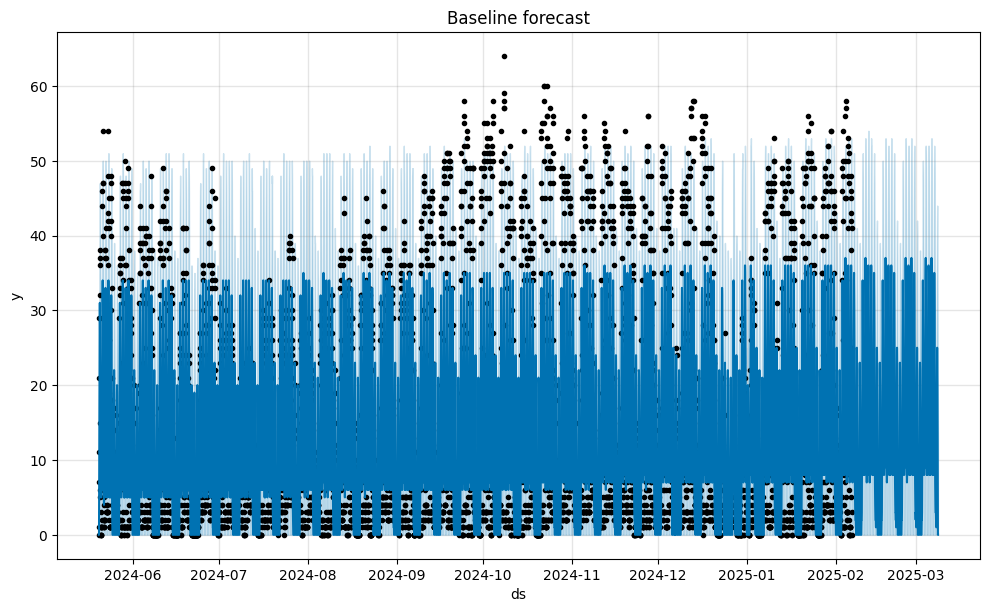

Baseline forecast components


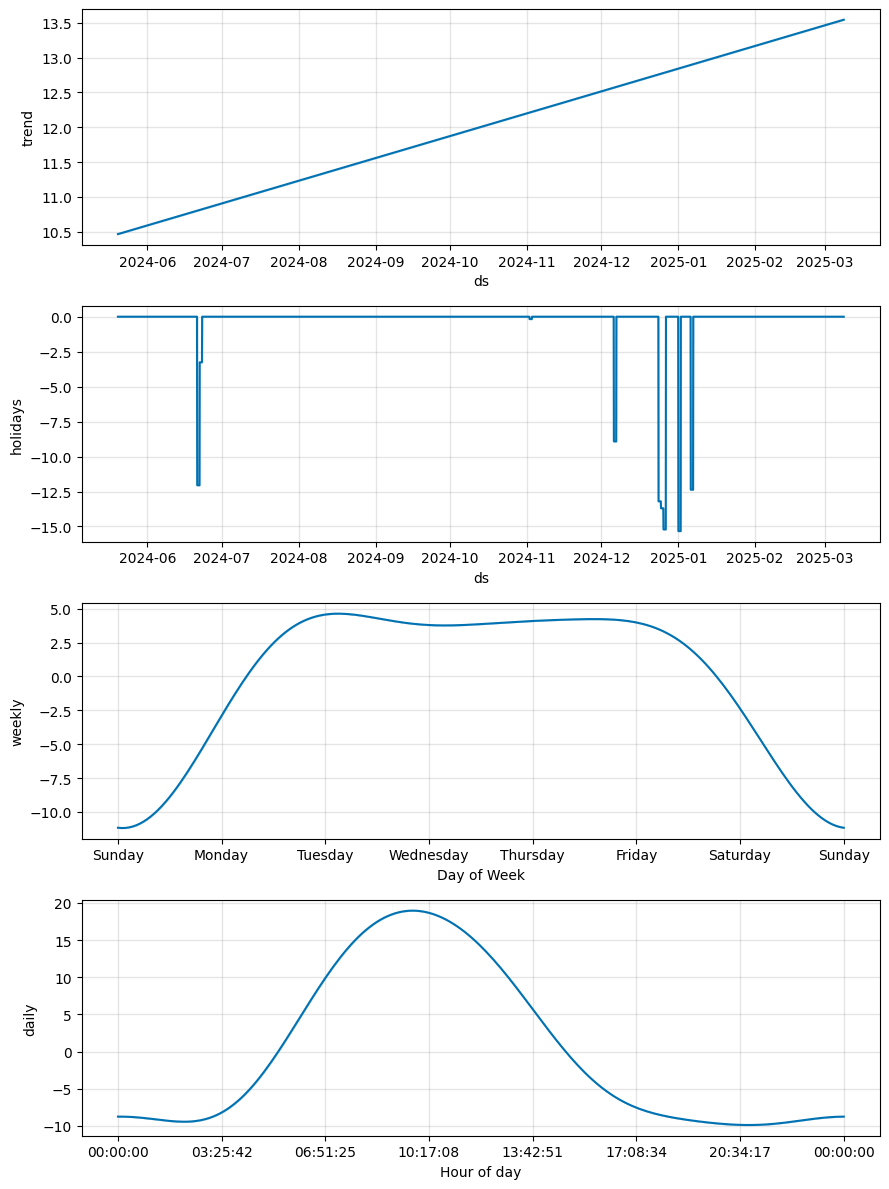

In [91]:
fig = baseline_model.plot(baseline_forecast)
plt.title('Baseline forecast')
plt.show()
fig2 = baseline_model.plot_components(baseline_forecast)
print('Baseline forecast components')
plt.show()

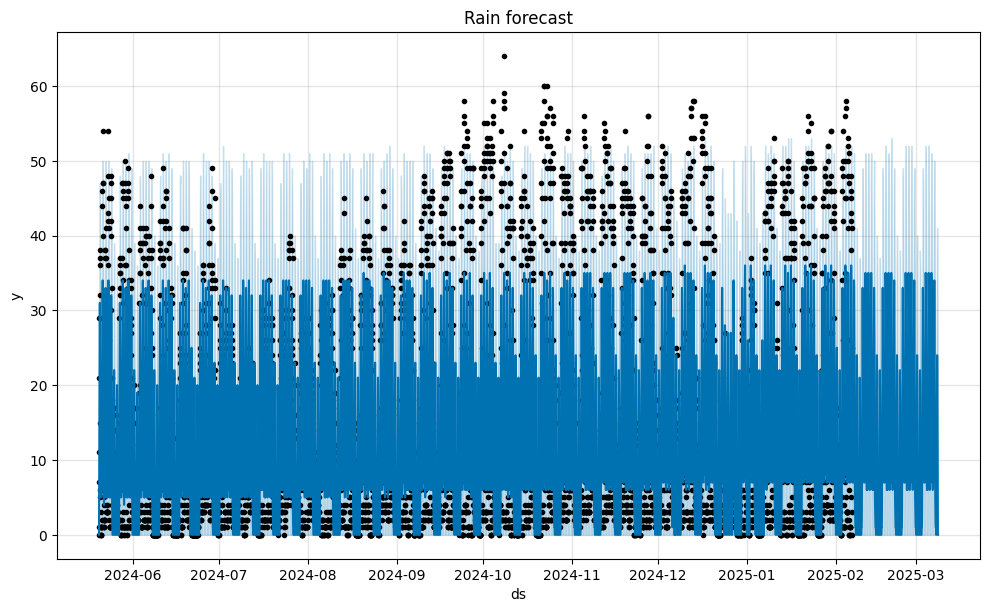

Rain forecast components


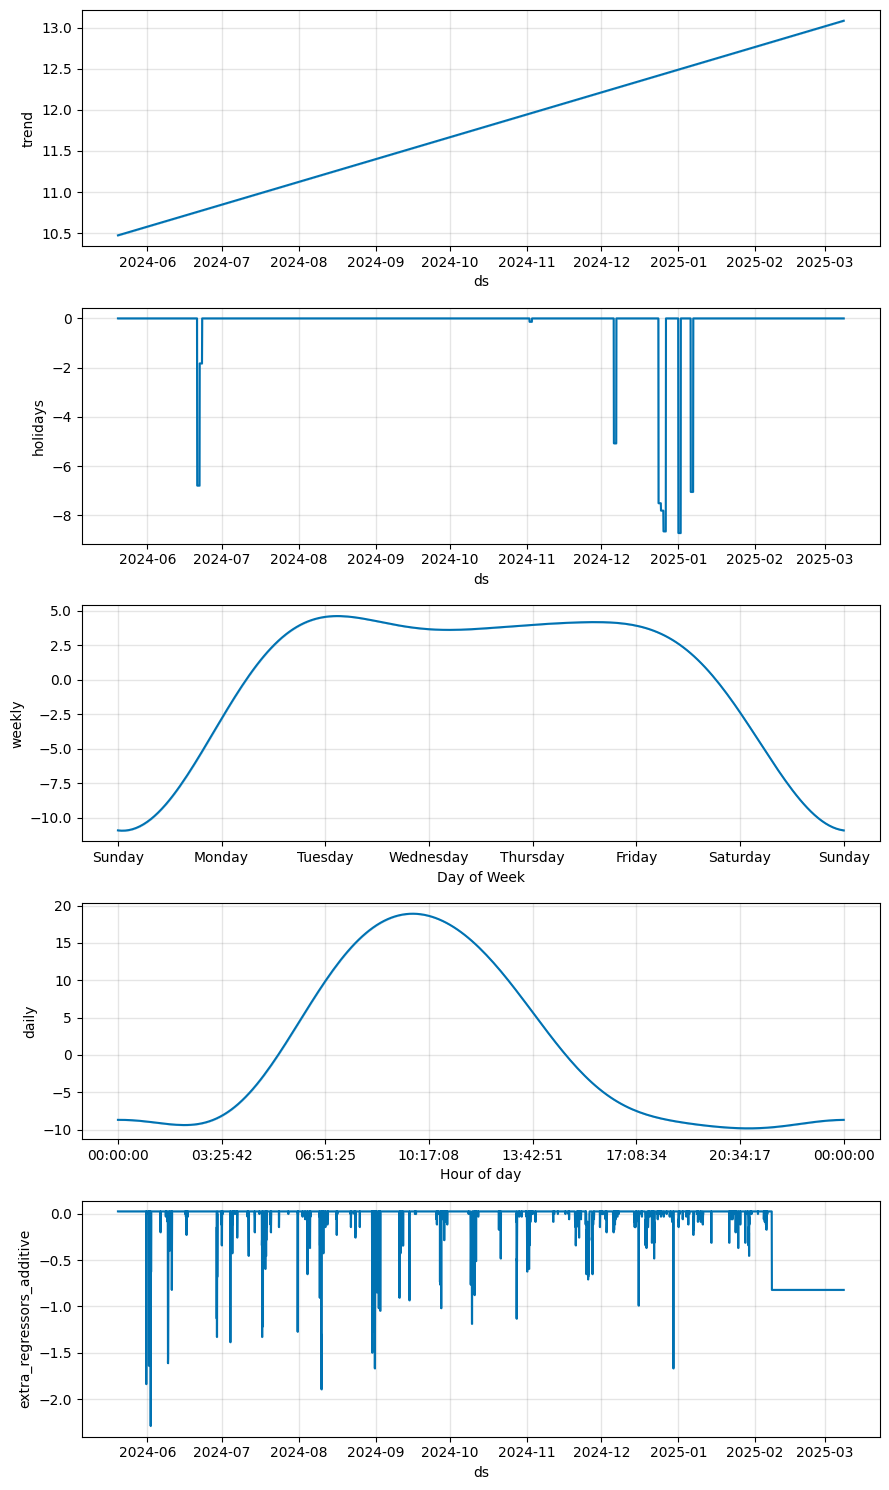

In [92]:
fig = rain_model.plot(rain_forecast)
plt.title('Rain forecast')
plt.show()
fig2 = rain_model.plot_components(rain_forecast)
print('Rain forecast components')
plt.show()

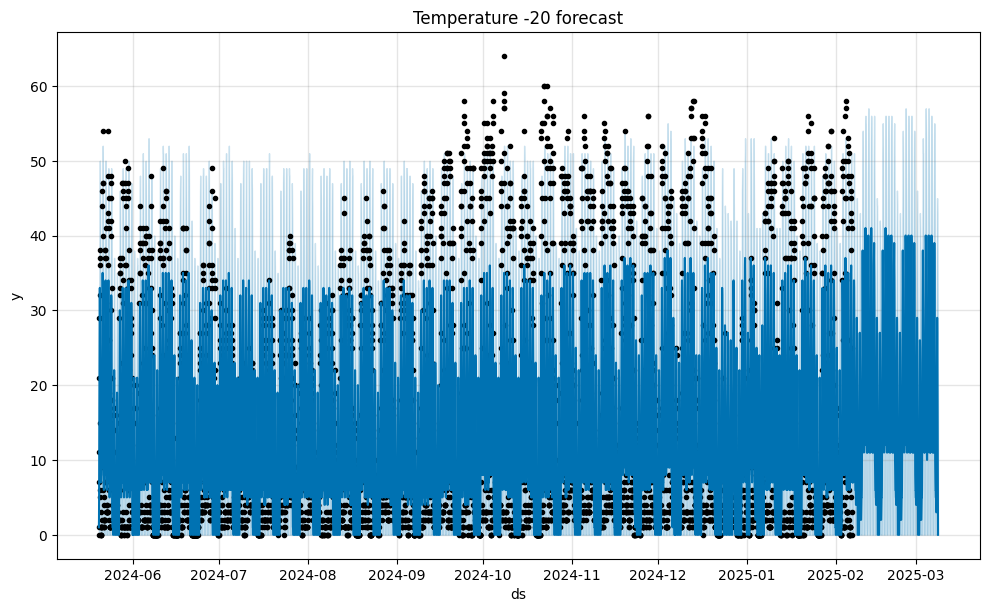

Temperature -20 forecast components


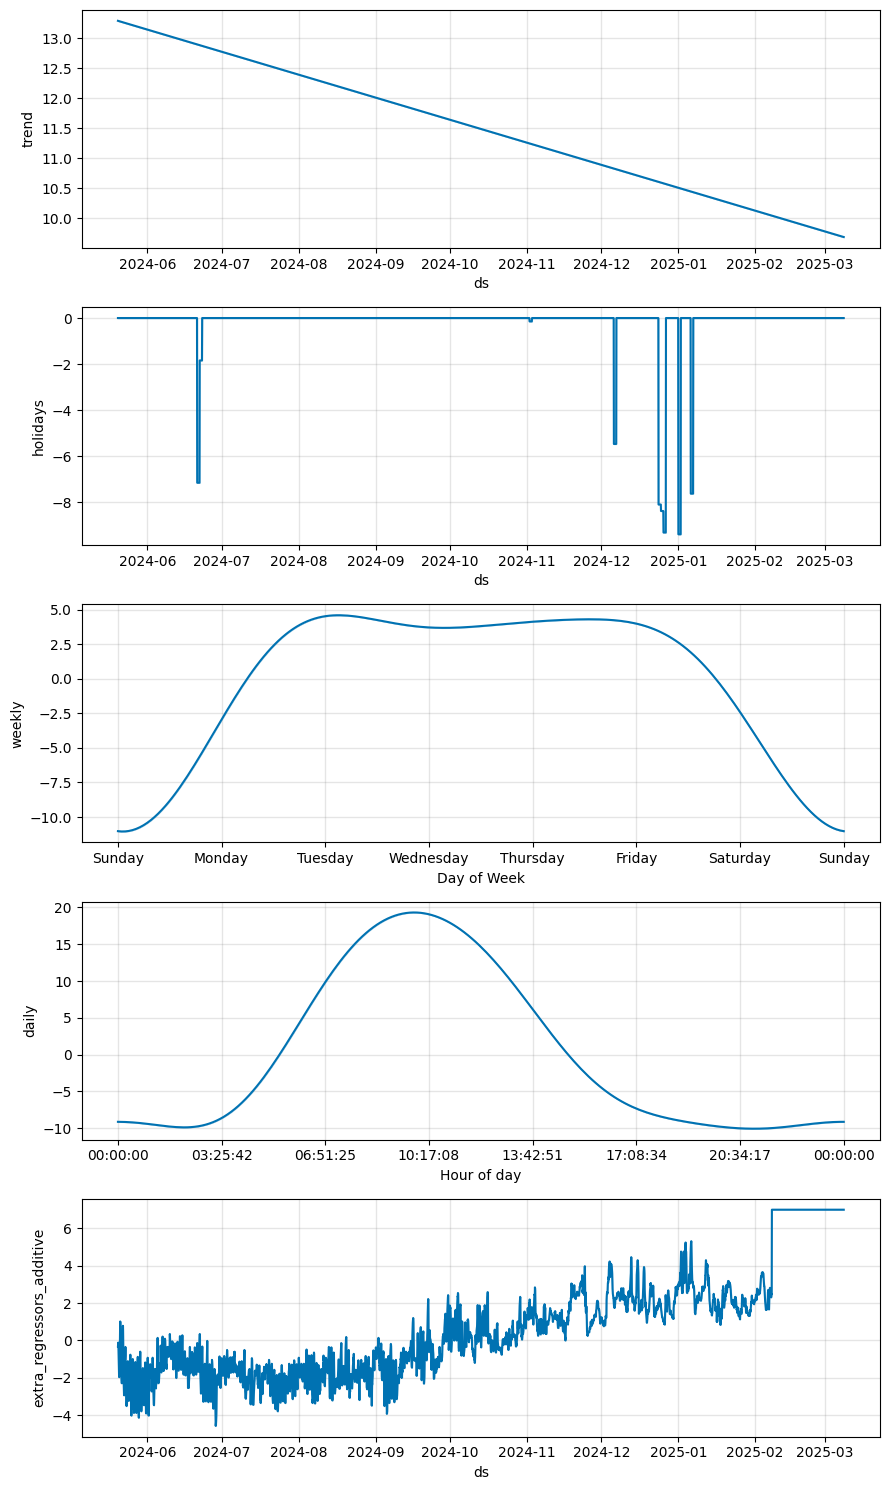

In [93]:
fig = temp_model_minus20.plot(temp_forecast_minus20)
plt.title('Temperature -20 forecast')
plt.show()
fig2 = temp_model_minus20.plot_components(temp_forecast_minus20)
print('Temperature -20 forecast components')
plt.show()

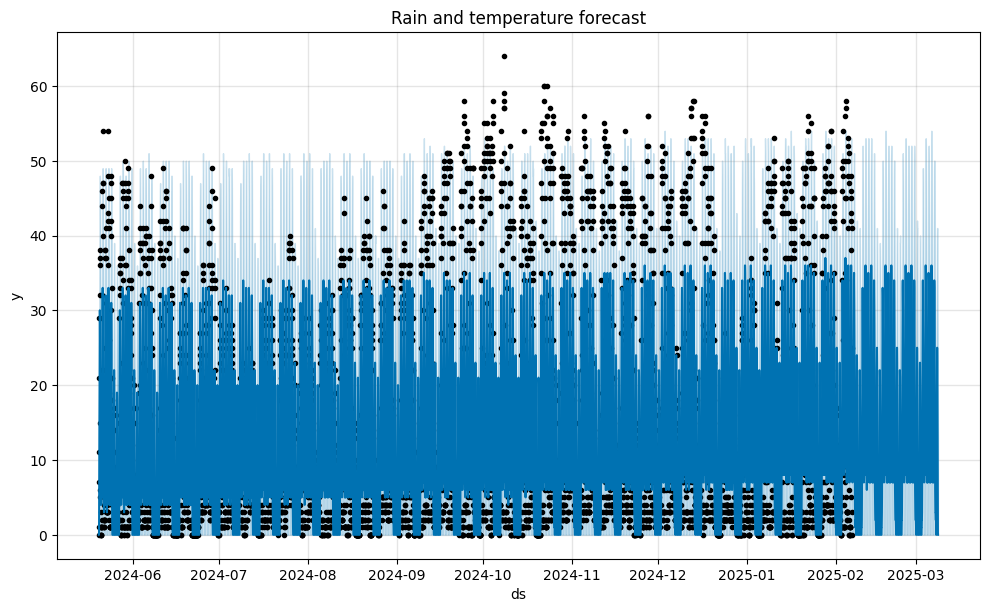

Rain and temperature forecast components


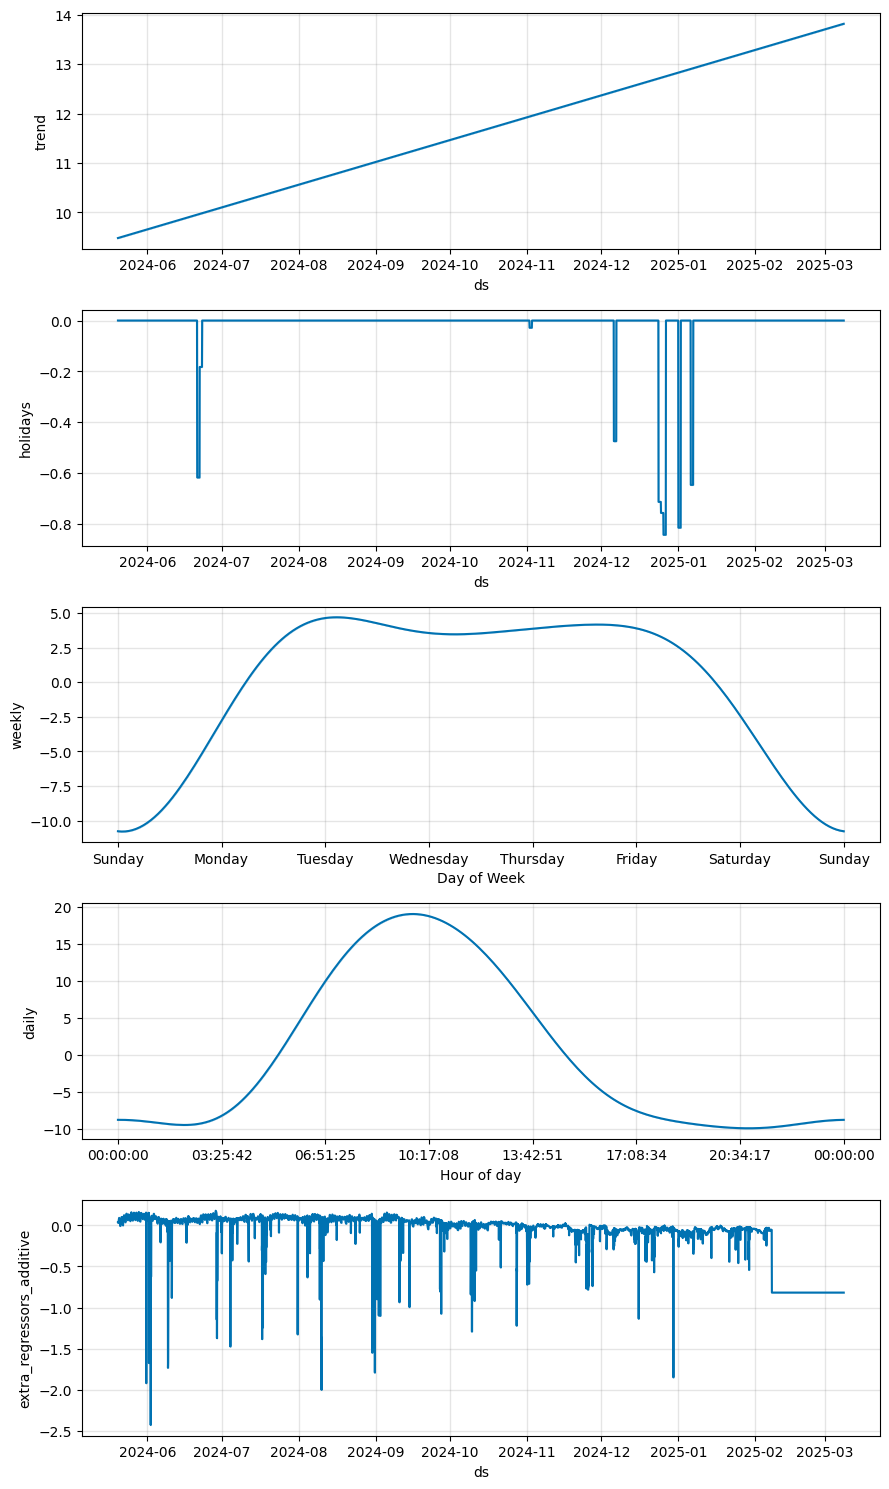

In [94]:
fig = rain_temp_model.plot(rain_temp_forecast)
plt.title('Rain and temperature forecast')
plt.show()
fig2 = rain_temp_model.plot_components(rain_temp_forecast)
print('Rain and temperature forecast components')
plt.show()

## Model performance metrics

In [95]:
base_cv = cross_validate(baseline_model, initial='120 days', period='7 days', horizon='14 days')
base_cv_p = performance_metrics(base_cv)
base_cv_p.head()
print('Baseline forecast performance metrics:')
print(base_cv_p.mean().to_string())

100%|██████████| 19/19 [00:04<00:00,  4.65it/s]

Baseline forecast performance metrics:
horizon     7 days 17:00:00
mse               99.603004
rmse               9.910543
mae                  7.7822
mdape              1.336056
smape              0.923456
coverage           0.864695


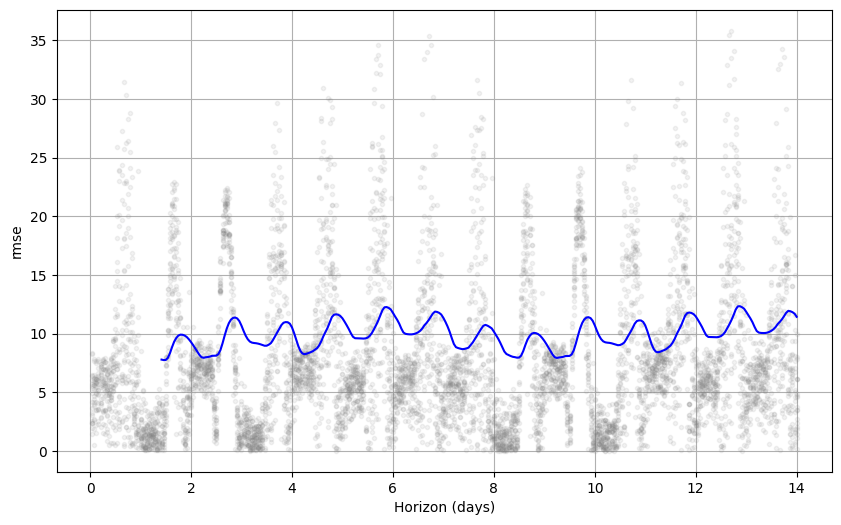

In [96]:
fig = plot_cross_validation_metric(base_cv, metric='rmse')

In [97]:
rain_cv = cross_validate(rain_model, initial='120 days', period='7 days', horizon='14 days')
rain_cv_p = performance_metrics(rain_cv)
rain_cv_p.head()
print('Rain forecast performance metrics:')
print(rain_cv_p.mean().to_string())

100%|██████████| 19/19 [00:04<00:00,  3.84it/s]

Rain forecast performance metrics:
horizon     7 days 17:00:00
mse                99.23527
rmse                9.89205
mae                7.764288
mdape              1.341816
smape              0.922729
coverage           0.865088


In [98]:
rain_bool_cv = cross_validate(rain_bool_model, initial='120 days', period='7 days', horizon='14 days')
rain_bool_cv_p = performance_metrics(rain_bool_cv)
rain_bool_cv_p.head()
print('Rain bool forecast performance metrics:')
print(rain_bool_cv_p.mean().to_string())

100%|██████████| 19/19 [00:04<00:00,  3.92it/s]

Rain bool forecast performance metrics:
horizon     7 days 17:00:00
mse              100.110318
rmse               9.935088
mae                7.800099
mdape              1.327158
smape              0.922306
coverage           0.864279


In [99]:
temp_minus20_cv = cross_validate(temp_model_minus20, initial='120 days', period='7 days', horizon='14 days')
temp_minus20_cv_p = performance_metrics(temp_minus20_cv)
temp_minus20_cv_p.head()
print('Temp forecast performance metrics:')
print(temp_minus20_cv_p.mean().to_string())

100%|██████████| 19/19 [00:04<00:00,  3.90it/s]

Temp forecast performance metrics:
horizon     7 days 17:00:00
mse               99.955012
rmse               9.929636
mae                 7.78074
mdape              1.341029
smape              0.925296
coverage           0.865203


In [100]:
rain_temp20_cv = cross_validate(rain_temp_model, initial='120 days', period='7 days', horizon='14 days')
rain_temp20_cv_p = performance_metrics(rain_temp20_cv)
rain_temp20_cv_p.head()
print('Rain+temp forecast performance metrics:')
print(rain_temp20_cv_p.mean().to_string())

100%|██████████| 19/19 [00:04<00:00,  3.99it/s]

Rain+temp forecast performance metrics:
horizon     7 days 17:00:00
mse              100.251375
rmse               9.944183
mae                7.780501
mdape              1.330061
smape              0.923648
coverage           0.862415


## Conclusions

### Model Accuracy Assessment

- **Error Magnitude**: RMSE (9.9) and MAE (7.8) indicate moderate forecasting errors (range 0-65).
- **Percentage Errors**:MDAPE (134%) and SMAPE (92%) are not useful metrics due to values being near to zero.
- **Coverage** (86%) is decent, where close to 95% would be ideal.

### Model Comparison

- Performance metrics across all baseline and weather models are nearly identical.
- Prophet forecasting with different rain and temperature parameters does not significantly improve or change forecasting accuracy.

## Weather Impact Analysis

Weather impact was measured by forecasting 30 days in future with given static weather values. Forecast total cars is a sum of all hourly cars in the 30 day period.

| Scenario | Forecast (Cars) | Difference from Baseline | Percentage Change |
|----------|----------------:|------------------------:|------------------:|
| Baseline | 9953.0 | - | - |
| Rain | 9137.0 | -816.0 | -8.2% |
| Rain Boolean | 8268.0 | -1685.0 | -16.9% |
| Temp -20°C | 12150.0 | +2197.0 | +22.1% |
| Temp -10°C | 10633.0 | +680.0 | +6.8% |
| Temp 0°C | 10108.0 | +155.0 | +1.6% |
| Temp +10°C | 7931.0 | -2022.0 | -20.3% |
| Temp +20°C | 6664.0 | -3289.0 | -33.1% |
| Rain & Temp +20°C | 9532.0 | -421.0 | -4.2% |

### Weather Effects Analysis
1. **Temperature Impact**: Strong and consistent linear relationship:
   - Very cold temperatures (-20°C) substantially increase traffic (+22.07%)
   - Very warm temperatures (+20°C) drastically decrease traffic (-33.05%)
   - A clear gradient effect with each 10°C increment/decrement

2. **Rain Effects**:
   - Boolean rain indicator shows stronger impact (-16.93%) than continuous rain measure (-8.20%)
   - Both rain indicators significantly reduce traffic

3. **Combined Effects**:
   - Rain & +20°C (-4.23%) shows a much smaller effect than expected if effects were additive
   - This suggests interaction effects where the combined impact is less than the sum of individual impacts
